In [38]:
%matplotlib inline
py.init_notebook_mode(connected=True)

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import datetime as dt
import seaborn as sns
import sys, os
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [40]:
# load data
# bitcoin = pd.read_csv('crypto_data/bitcoin_price.csv')

__split = '2017-09-01'
__window = 2
__supported_coins = ['bitcoin', 'bitcoin_cash', 'bitconnect', 'dash', 'ethereum', 'ethereum_classic', 'iota', 'litecoin', 'monero', 
                     'nem', 'neo', 'numeraire', 'omisego', 'qtum', 'ripple', 'stratis', 'waves']

In [41]:
def load_dataset(elem):
    if elem in __supported_coins:
        csv = pd.read_csv('crypto_data/' + elem + '_price.csv')
    else:
        print("No such file '{}'".format(elem), file=sys.stderr)
    return csv

In [42]:
data = load_dataset('bitcoin')

In [43]:
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Feb 20, 2018",11231.8,11958.5,11231.80,11403.7,"9,926,540,000","189,536,000,000"
1,"Feb 19, 2018",10552.6,11273.8,10513.20,11225.3,"7,652,090,000","178,055,000,000"
2,"Feb 18, 2018",11123.4,11349.8,10326.00,10551.8,"8,744,010,000","187,663,000,000"
3,"Feb 17, 2018",10207.5,11139.5,10149.40,11112.7,"8,660,880,000","172,191,000,000"
4,"Feb 16, 2018",10135.7,10324.1,9824.82,10233.9,"7,296,160,000","170,960,000,000"


In [44]:
# remove commas, set unavalable data to 0, convert to float
data['Volume'] = data['Volume'].apply(lambda n: n.split()[0].replace(',', ''))
data.loc[data['Volume'] == "-",'Volume'] = 0
data['Volume'] = data['Volume'].astype('int64')

In [45]:
# remove commas, convert to float
data['Market Cap'] = data['Market Cap'].apply(lambda n: n.split()[0].replace(',', ''))
data['Market Cap'] = data['Market Cap'].astype('int64')

In [46]:
# convert date
data['Date'] = pd.to_datetime(data['Date'])

In [47]:
# data.sort_values('Date', inplace=True)
data.set_index('Date', inplace=True)

In [48]:
# add new relevant features
data['Volatility'] = (data['High'] - data['Low']) / data['Open']
data['Close_High_Gap'] = data['Close'] - data['High']

In [49]:
data.head()

,Open,High,Low,Close,Volume,Market Cap,Volatility,Close_High_Gap
Date,,,,,,,,
2018-02-20,11231.8,11958.5,11231.80,11403.7,9926540000,189536000000,0.064700,-554.8
2018-02-19,10552.6,11273.8,10513.20,11225.3,7652090000,178055000000,0.072077,-48.5
2018-02-18,11123.4,11349.8,10326.00,10551.8,8744010000,187663000000,0.092040,-798.0
2018-02-17,10207.5,11139.5,10149.40,11112.7,8660880000,172191000000,0.096997,-26.8
2018-02-16,10135.7,10324.1,9824.82,10233.9,7296160000,170960000000,0.049260,-90.2


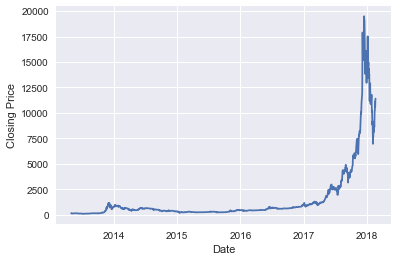

In [50]:
fig, ax = plt.subplots()
ax.set_ylabel('Closing Price')
ax.set_xlabel('Date')
ax.plot(data.index, data['Close'])
plt.show()

In [51]:
# normalize
data = data / data.iloc[0] - 1

In [52]:
data.head(20)

,Open,High,Low,Close,Volume,Market Cap,Volatility,Close_High_Gap
Date,,,,,,,,
2018-02-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-02-19,-0.060471,-0.057256,-0.063979,-0.015644,-0.229128,-0.060574,0.114015,-0.912581
2018-02-18,-0.009651,-0.050901,-0.080646,-0.074704,-0.119128,-0.009882,0.422564,0.438356
2018-02-17,-0.091196,-0.068487,-0.096369,-0.025518,-0.127503,-0.091513,0.499180,-0.951694
2018-02-16,-0.097589,-0.136673,-0.125268,-0.102581,-0.264985,-0.098008,-0.238650,-0.837419
2018-02-15,-0.155227,-0.144140,-0.163484,-0.108500,-0.087039,-0.155701,0.367038,-0.876712
2018-02-14,-0.234324,-0.204036,-0.234324,-0.167408,-0.203164,-0.234852,0.650957,-0.956903
2018-02-13,-0.205228,-0.250870,-0.247190,-0.246007,-0.426112,-0.205871,-0.128992,-0.350829
2018-02-12,-0.275145,-0.248575,-0.275145,-0.217222,-0.369726,-0.275821,0.603201,-0.893025


In [53]:
train, test = data[data.index < __split], data[data.index >= __split]

In [54]:
train_pt = []
test_pt = []

for elem in range(len(train) - __window):
    train_temp = train[elem : (elem + __window)].copy()
    train_temp = train_temp / train_temp.iloc[0] - 1
    train_pt.append(train_temp)
    
train_y_pts = (train['Close'][__window:].values / train['Close'][: - __window].values) - 1
train_pt = [np.array(elem) for elem in train_pt]
train_pt = np.array(train_pt)

for elem in range(len(test) - __window):
    test_temp = test[elem : (elem + __window)].copy()
    test_temp = test_temp / test_temp.iloc[0] - 1
    test_pt.append(test_temp)
    
test_y_pts = (test['Close'][__window:].values / test['Close'][: - __window].values) - 1
test_pt = [np.array(elem) for elem in test_pt]
test_pt = np.array(test_pt)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning:

divide by zero encountered in true_divide



In [55]:
train.head()

,Open,High,Low,Close,Volume,Market Cap,Volatility,Close_High_Gap
Date,,,,,,,,
2017-08-31,-0.594403,-0.603960,-0.594954,-0.587556,-0.804068,-0.602596,-0.366747,-0.941132
2017-08-30,-0.593087,-0.613119,-0.601897,-0.599665,-0.804781,-0.601360,-0.475454,-0.889654
2017-08-29,-0.609216,-0.613189,-0.612517,-0.598462,-0.749552,-0.617203,-0.036738,-0.915898
2017-08-28,-0.609640,-0.631732,-0.623868,-0.615681,-0.802617,-0.617656,-0.367974,-0.961662
2017-08-27,-0.613143,-0.630674,-0.615619,-0.615662,-0.845116,-0.621132,-0.646781,-0.939239


In [56]:
# check which features have low or negative importance
reg_X = train
reg_X.drop('Close', axis=1)
reg_y = train['Close']

regressor = RandomForestRegressor()
regressor.fit(reg_X, reg_y)
regressor.feature_importances_


array([2.43819148e-01, 1.74778555e-01, 8.19265874e-02, 3.30461222e-01,
       9.36163994e-05, 1.68827585e-01, 6.20937984e-05, 3.11925885e-05])

In [57]:
# get low importance indices
indices = np.argsort(regressor.feature_importances_)[::-1]
indices

array([3, 0, 1, 5, 2, 4, 6, 7])

In [58]:
# volatility, close_high_gap and volume have the lowest importance

In [59]:
# # model for first iteration
# data_model = Sequential()
# data_model.add(LSTM(20, input_shape=(train_pt.shape[1], train_pt.shape[2])))
# data_model.add(Dropout(0.25))
# data_model.add(Dense(units=1))
# data_model.add(Activation("linear"))
# data_model.compile(loss="mae", optimizer="adam")
# train_res = (train['Close'][__window : ].values / train['Close'][ : - __window].values) - 1
# data_hist = data_model.fit(train_pt, train_res, epochs = 1, batch_size = 1, verbose = 1, shuffle = True)

In [60]:
# remove features with low importance
train, test = data[data.index < __split], data[data.index >= __split]
train.drop(['Volume', 'Volatility', 'Close_High_Gap'], axis=1, inplace=True)
test.drop(['Volume', 'Volatility', 'Close_High_Gap'], axis=1, inplace=True)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [61]:
train_pt = []
test_pt = []

for elem in range(len(train) - __window):
    train_temp = train[elem : (elem + __window)].copy()
    train_temp = train_temp / train_temp.iloc[0] - 1
    train_pt.append(train_temp)
    
train_y_pts = (train['Close'][__window:].values / train['Close'][: - __window].values) - 1
train_pt = [np.array(elem) for elem in train_pt]
train_pt = np.array(train_pt)

for elem in range(len(test) - __window):
    test_temp = test[elem : (elem + __window)].copy()
    test_temp = test_temp / test_temp.iloc[0] - 1
    test_pt.append(test_temp)
    
test_y_pts = (test['Close'][__window:].values / test['Close'][: - __window].values) - 1
test_pt = [np.array(elem) for elem in test_pt]
test_pt = np.array(test_pt)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning:

divide by zero encountered in true_divide



In [62]:
# # retrain with same model but removed features - proj 2
# data_model_lf = Sequential()
# data_model_lf.add(LSTM(20, input_shape=(train_pt.shape[1], train_pt.shape[2])))
# data_model_lf.add(Dropout(0.25))
# data_model_lf.add(Dense(units=1))
# data_model_lf.add(Activation("linear"))
# data_model_lf.compile(loss="mae", optimizer="adam")
# train_res = (train['Close'][__window : ].values / train['Close'][ : - __window].values) - 1
# data_hist_lf = data_model_lf.fit(train_pt, train_res, epochs = 50, batch_size = 20, verbose = 1, shuffle = True)

In [63]:
# retrain with same model but removed features, changed the following 
# different dropout, loss, hidden layers, num of epochs, batch - proj 2-3

data_model_ch = Sequential()
data_model_ch.add(LSTM(200, return_sequences=True, input_shape=(train_pt.shape[1], train_pt.shape[2])))
data_model_ch.add(Dropout(0.2, noise_shape=None, seed=None))
data_model_ch.add(LSTM(200))
data_model_ch.add(Dropout(0.2, noise_shape=None, seed=None))
data_model_ch.add(Dense(1))
data_model_ch.add(Activation("linear"))
data_model_ch.compile(loss="mean_squared_error", optimizer="adam")
train_res = (train['Close'][__window : ].values / train['Close'][ : - __window].values) - 1
data_hist = data_model_ch.fit(train_pt, train_res, epochs = 50, batch_size = 20, verbose = 1, shuffle = True)

Epoch 1/50
1585/1585 [==============================] - 2s 1ms/step - loss: 4.9801e-05
Epoch 2/50
1585/1585 [==============================] - 1s 537us/step - loss: 3.7310e-05
Epoch 3/50
1585/1585 [==============================] - 1s 539us/step - loss: 1.5448e-05
Epoch 4/50
1585/1585 [==============================] - 1s 532us/step - loss: 5.0638e-06
Epoch 5/50
1585/1585 [==============================] - 1s 540us/step - loss: 3.7364e-06
Epoch 6/50
1585/1585 [==============================] - 1s 536us/step - loss: 3.5329e-06
Epoch 7/50
1585/1585 [==============================] - 1s 532us/step - loss: 2.5527e-06
Epoch 8/50
1585/1585 [==============================] - 1s 554us/step - loss: 2.8516e-06
Epoch 9/50
1585/1585 [==============================] - 1s 540us/step - loss: 2.1089e-06
Epoch 10/50
1585/1585 [==============================] - 1s 548us/step - loss: 2.6292e-06
Epoch 11/50
1585/1585 [==============================] - 1s 543us/step - loss: 2.3491e-06
Epoch 12/50
1585/1585

In [64]:
# # old training set error
# fig, ax = plt.subplots()
# ax.plot(data_hist_lf.epoch, data_hist_lf.history['loss'])
# ax.set_title('Old Training Set Error')
# ax.set_ylabel('Mean Absolute Error',fontsize=12)
# ax.set_xlabel('Epochs',fontsize=12)
# plt.show()

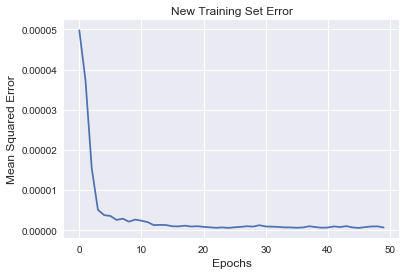

In [65]:
# new training set error
fig, ax = plt.subplots()
ax.plot(data_hist.epoch, data_hist.history['loss'])
ax.set_title('New Training Set Error')
ax.set_ylabel('Mean Squared Error',fontsize=12)
ax.set_xlabel('Epochs',fontsize=12)
plt.show()

In [66]:
def drawing(true, predict):
    RMSE = sqrt(mean_squared_error(true['Close'][__window+1:], predict[0][1:]))
    print('RMSE: %.3f' % RMSE)
    
    model = go.Scatter(x = np.arange(0, len(predict), 1), y = predict[0][0:], mode = 'lines', name = 'Price Prediction', hoverlabel = dict(namelength=-1), line = dict(color=('rgb(0, 191, 255)'), width=2))
    real = go.Scatter(x = np.arange(0, len(true), 1), y = true['Close'][__window:], mode = 'lines', name = 'Actual Price', line = dict(color=('rgb(205, 92, 92)'), width=2))
    data = [model, real]
    layout = dict(title = 'Actual vs Predicted', xaxis = dict(title = 'Day'), yaxis = dict(title = 'Price'))
    fig = dict(data=data, layout=layout)
    py.iplot(fig)

In [67]:
train['Close'][__window:]

# predictions 1 day
predictions = ((np.transpose(data_model_ch.predict(train_pt)) + 1) * train['Close'].values[: - __window])
predct_df = pd.DataFrame(data = predictions[0,0:])

In [68]:
predct_df

,0
0,-0.598471
1,-0.614314
2,-0.616211
3,-0.619262
4,-0.616329
5,-0.620149
6,-0.636859
7,-0.639869
8,-0.648633
9,-0.641216


In [69]:
test['Close'][__window:]

# predictions 1 day
predictions_test = ((np.transpose(data_model_ch.predict(test_pt)) + 1) * test['Close'].values[: - __window])
pred_df = pd.DataFrame(data = predictions_test[0,0:])
pred_df[0].fillna(0,inplace=True)

In [70]:
pred_df

,0
0,0.000000
1,-0.043202
2,-0.230044
3,-0.071924
4,-0.164489
5,-0.210201
6,-0.223272
7,-0.299009
8,-0.252716
9,-0.233852


In [71]:
# train prediciton plot
drawing(train, predct_df)

RMSE: 0.001


In [72]:
# test prediction plot
drawing(test, pred_df)

RMSE: 0.047


In [73]:
# gru
gru_model = Sequential()
gru_model.add(GRU(200, input_shape=(train_pt.shape[1], train_pt.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_train = (train['Close'][__window : ].values / train['Close'][ : - __window].values) - 1
gru_data = gru_model.fit(train_pt, gru_train, epochs = 50, batch_size = 20, verbose = 1, shuffle = True)


Epoch 1/50
1585/1585 [==============================] - 1s 708us/step - loss: 3.3908e-05
Epoch 2/50
1585/1585 [==============================] - 0s 227us/step - loss: 6.9828e-06
Epoch 3/50
1585/1585 [==============================] - 0s 234us/step - loss: 4.3632e-06
Epoch 4/50
1585/1585 [==============================] - 0s 227us/step - loss: 3.0627e-06
Epoch 5/50
1585/1585 [==============================] - 0s 229us/step - loss: 2.5518e-06
Epoch 6/50
1585/1585 [==============================] - 0s 227us/step - loss: 1.7673e-06
Epoch 7/50
1585/1585 [==============================] - 0s 228us/step - loss: 1.7049e-06
Epoch 8/50
1585/1585 [==============================] - 0s 227us/step - loss: 1.1004e-06
Epoch 9/50
1585/1585 [==============================] - 0s 229us/step - loss: 7.7491e-07
Epoch 10/50
1585/1585 [==============================] - 0s 225us/step - loss: 6.3583e-07
Epoch 11/50
1585/1585 [==============================] - 0s 224us/step - loss: 8.2032e-07
Epoch 12/50
1585/15

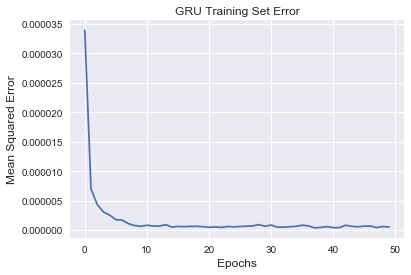

In [74]:
# gru training set error
fig, ax = plt.subplots()
ax.plot(gru_data.epoch, gru_data.history['loss'])
ax.set_title('GRU Training Set Error')
ax.set_ylabel('Mean Squared Error',fontsize=12)
ax.set_xlabel('Epochs',fontsize=12)
plt.show()

In [75]:
# gru preds
train['Close'][__window:]

# predictions 1 day
gru_tr_predictions = ((np.transpose(gru_model.predict(train_pt)) + 1) * train['Close'].values[: - __window])
gru_predct_df = pd.DataFrame(data = gru_tr_predictions[0,0:])

In [76]:
gru_predct_df

,0
0,-0.599038
1,-0.613960
2,-0.616716
3,-0.619866
4,-0.616780
5,-0.620591
6,-0.636429
7,-0.640493
8,-0.647879
9,-0.642953


In [77]:
# gru test preds
test['Close'][__window:]

# predictions 1 day
gru_predictions_test = ((np.transpose(gru_model.predict(test_pt)) + 1) * test['Close'].values[: - __window])
gru_pred_df = pd.DataFrame(data = gru_predictions_test[0,0:])
gru_pred_df[0].fillna(0,inplace=True)

In [78]:
gru_pred_df

,0
0,0.000000
1,-0.056454
2,-0.411379
3,-0.096004
4,-0.163993
5,-0.217010
6,-0.226248
7,-0.295278
8,-0.255362
9,-0.234102


In [79]:
# gru train prediciton plot
drawing(train, gru_predct_df)

RMSE: 0.001


In [80]:
# gru test prediction plot
drawing(test, gru_pred_df)

RMSE: 0.064


In [81]:
# optimized mod
optimized_mod = Sequential()
optimized_mod.add(LSTM(200, return_sequences=True, input_shape=(train_pt.shape[1], train_pt.shape[2])))
optimized_mod.add(Dropout(0.2, noise_shape=None, seed=None))
optimized_mod.add(LSTM(200))
optimized_mod.add(Dropout(0.2, noise_shape=None, seed=None))
optimized_mod.add(Dense(1))
optimized_mod.add(Activation("linear"))
optimized_mod.compile(loss="mean_squared_error", optimizer="rmsprop")
opt_train_res = (train['Close'][__window : ].values / train['Close'][ : - __window].values) - 1
opt_mod_hist = optimized_mod.fit(train_pt, opt_train_res, epochs = 50, batch_size = 20, verbose = 1, shuffle = True)

Epoch 1/50
1585/1585 [==============================] - 2s 1ms/step - loss: 6.2947e-05
Epoch 2/50
1585/1585 [==============================] - 1s 508us/step - loss: 4.1124e-05
Epoch 3/50
1585/1585 [==============================] - 1s 501us/step - loss: 1.8901e-05
Epoch 4/50
1585/1585 [==============================] - 1s 495us/step - loss: 7.2474e-06
Epoch 5/50
1585/1585 [==============================] - 1s 489us/step - loss: 4.8170e-06
Epoch 6/50
1585/1585 [==============================] - 1s 509us/step - loss: 4.1181e-06
Epoch 7/50
1585/1585 [==============================] - 1s 510us/step - loss: 3.7866e-06
Epoch 8/50
1585/1585 [==============================] - 1s 511us/step - loss: 3.3530e-06
Epoch 9/50
1585/1585 [==============================] - 1s 520us/step - loss: 3.0392e-06
Epoch 10/50
1585/1585 [==============================] - 1s 505us/step - loss: 2.7561e-06
Epoch 11/50
1585/1585 [==============================] - 1s 507us/step - loss: 2.5350e-06
Epoch 12/50
1585/1585

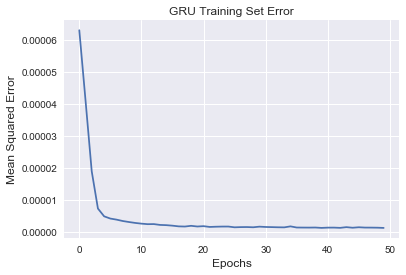

In [82]:
# opt model training set error
fig, ax = plt.subplots()
ax.plot(opt_mod_hist.epoch, opt_mod_hist.history['loss'])
ax.set_title('GRU Training Set Error')
ax.set_ylabel('Mean Squared Error',fontsize=12)
ax.set_xlabel('Epochs',fontsize=12)
plt.show()

In [83]:
# opt preds
train['Close'][__window:]

# predictions 1 day
opt_tr_predictions = ((np.transpose(optimized_mod.predict(train_pt)) + 1) * train['Close'].values[: - __window])
opt_predct_df = pd.DataFrame(data = opt_tr_predictions[0,0:])

In [84]:
opt_predct_df

,0
0,-0.598112
1,-0.613898
2,-0.616436
3,-0.618020
4,-0.615179
5,-0.618754
6,-0.636905
7,-0.639920
8,-0.648572
9,-0.639679


In [85]:
# opt test preds
test['Close'][__window:]

# opt predictions 1 day
opt_predictions_test = ((np.transpose(optimized_mod.predict(test_pt)) + 1) * test['Close'].values[: - __window])
opt_pred_df = pd.DataFrame(data = opt_predictions_test[0,0:])
opt_pred_df[0].fillna(0,inplace=True)

In [86]:
opt_pred_df

,0
0,0.000000
1,-0.037878
2,-0.192109
3,-0.062536
4,-0.165607
5,-0.207399
6,-0.226221
7,-0.301152
8,-0.255019
9,-0.229207


In [87]:
# optimized train prediciton plot
drawing(train, opt_predct_df)

RMSE: 0.002


In [88]:
# optimized test prediction plot
drawing(test, opt_pred_df)

RMSE: 0.043
